# Keras Text Classification example

We'll use the Reuters newswire dataset of 11,228 newswires from Reuters, labeled over 46 topics.

Each wire is encoded as a sequence of word indexes (same conventions).

In [1]:
import numpy as np
np.random.seed(1)
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(test_split=0.2)

There are 46 topics, keep only the first 3.

In [3]:
keep_train = Y_train < 4

X_train = X_train[keep_train]
Y_train = Y_train[keep_train]

In [4]:
keep_test = Y_test < 4

X_test = X_test[keep_test]
Y_test = Y_test[keep_test]

## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the review. Each label is an integer value between 0 and 3.

In [5]:
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
print(set(Y_train))

{0, 1, 2, 3}


We'll have 3720 train records and 950 test records.

In [7]:
len(X_train)

3720

In [8]:
len(X_test)

950

This dataset also makes available the word index used for encoding the sequences on a dictionary mapping words to an integer index:

In [9]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [10]:
word_index['attorney']

7249

In [11]:
word_index['rain']

2074

In [12]:
word_index['dog']

11680

## Convert the integers back to words

It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [14]:
reverse_word_index[7249]

'attorney'

In [15]:
reverse_word_index[2074]

'rain'

In [16]:
reverse_word_index[11680]

'dog'

In [17]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [18]:
decode_review(X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

## Prepare the data

The the arrays of integers must be converted to _tensors_ before fed into the neural network.

We'll convert the arrays into vectors of 0s or 1s indicating word occurrence, similar to a one-hot encoding. For example, the sequence [3, 5] would become a vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network _—a Dense layer—_ that can handle floating point vector data.

This approach is memory intensive, though, requiring a num_words * num_newswire size matrix.

In [19]:
max_words = 5000
num_classes = max(Y_train) + 1

In [20]:
tokenizer = Tokenizer(num_words=max_words)

X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

Also, we need to convert our labels to categorical values. For example, the value 3 would become 4-dimensional vector that is all zeros except for 3 index, which is one.

In [21]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [22]:
print(X_train[0][0:20])
print(len(X_train[0]))

print(Y_train[0])
print(len(Y_train[0]))

[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.]
5000
[0. 0. 0. 1.]
4


## Create our classification model

In [23]:
model = Sequential()

model.add(Dense(512, input_shape=(max_words,), activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.metrics_names)

model.summary()

['loss', 'acc']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 2,562,564
Trainable params: 2,562,564
Non-trainable params: 0
_________________________________________________________________


In [25]:
batch_size = 32
epochs = 5

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3720 samples, validate on 950 samples
Epoch 1/5
3720/3720 [==============================] - 26s 7ms/step - loss: 0.2095 - acc: 0.9417 - val_loss: 0.1328 - val_acc: 0.9684
Epoch 2/5
3720/3720 [==============================] - 25s 7ms/step - loss: 0.0450 - acc: 0.9903 - val_loss: 0.1265 - val_acc: 0.9716
Epoch 3/5
3720/3720 [==============================] - 25s 7ms/step - loss: 0.0275 - acc: 0.9949 - val_loss: 0.1489 - val_acc: 0.9716
Epoch 4/5
3720/3720 [==============================] - 25s 7ms/step - loss: 0.0225 - acc: 0.9949 - val_loss: 0.1462 - val_acc: 0.9695
Epoch 5/5
3720/3720 [==============================] - 25s 7ms/step - loss: 0.0210 - acc: 0.9944 - val_loss: 0.1540 - val_acc: 0.9705


## Evaluate the model

And let's see how the model performs. Two values will be returned:

- Loss (a number which represents our error, lower values are better)
- Accuracy.

In [26]:
score = model.evaluate(X_test,
                       Y_test,
                       batch_size=batch_size,
                       verbose=1)

print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1], 3))

950/950 [==============================] - 1s 843us/step
Test loss: 0.154
Test accuracy: 0.971


In [28]:
Y_pred = model.predict(X_test)

Y_test_class = np.argmax(Y_test, axis=1)
Y_pred_class = np.argmax(Y_pred, axis=1)

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test_class, Y_pred_class))
print(confusion_matrix(Y_test_class, Y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.92      0.88      0.90       105
           2       0.88      0.75      0.81        20
           3       0.98      0.99      0.99       813

   micro avg       0.97      0.97      0.97       950
   macro avg       0.95      0.82      0.87       950
weighted avg       0.97      0.97      0.97       950

[[  8   1   0   3]
 [  0  92   0  13]
 [  0   3  15   2]
 [  0   4   2 807]]


## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

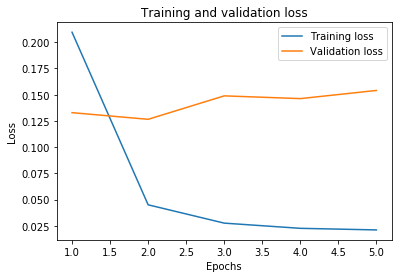

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

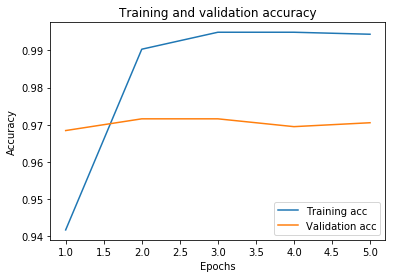

In [31]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()